Implementation of the classical MNIST FC and Conv classifier
==================================================

Mirror on GitHub: https://gist.github.com/Meehai/85429f878e319a70116a9d72aaf83ac1

First, do the imports, in our case we need the readers for Cifar10 and MNIST, as well as some built-in callbacks

In [3]:
%matplotlib inline
import sys
import numpy as np
import torch as tr
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from neural_wrappers.readers import MNISTReader
from neural_wrappers.pytorch import NeuralNetworkPyTorch, maybeCuda
from neural_wrappers.callbacks import SaveModels, ConfusionMatrix
from neural_wrappers.metrics import Accuracy
import matplotlib.pyplot as plt


Then, we need some global parameters, such as the path in the local directory to the dataset or the type of model used.

In [4]:
datasetPath = "/home/mihai/Public/Datasets/mnist/mnist.h5"

reader = MNISTReader(datasetPath, normalizer={"images" : "standardization"})
print(reader.summary())

[MNIST Reader] Setup complete
[Dataset summary]
General dataset reader. Update __str__ in your dataset for more details when using summary.
All dims: ['images', 'labels']. Data dims: ['images']. Label dims: ['labels']
Dim transforms: {'images': <class 'numpy.float32'>, 'labels': <function MNISTReader.<lambda> at 0x7f4386710510>}
Normalizers: {'images': 'standardization', 'labels': 'identity'}
Aug Transforms(1):
[Transformer]
  - {'images': 'identity', 'labels': 'identity'}



Based on the model type, import it, using the inputShape/outputShape pair, and set the optimizer, metrics and criterion. For optimizer, simple SGD with momentum works. For criterion, the NLL is used, because the task is classification. Finally, we add Accuracy as metric (alongside Loss, which is by default) also specifying that the data is given as categorical (one-hot encoded vector).

In [6]:
class ModelFC(NeuralNetworkPyTorch):
    # (28, 28, 1) => (10, 1)
    def __init__(self, inputShape, outputNumClasses):
        super().__init__()

        self.inputShapeProd = int(np.prod(np.array(inputShape)))
        self.fc1 = nn.Linear(self.inputShapeProd, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, outputNumClasses)

    def forward(self, x):
        x = x.view(-1, self.inputShapeProd)
        y1 = self.fc1(x)
        y2 = self.fc2(y1)
        y3 = self.fc3(y2)
        return y3

def lossFn(y, t):
    # Negative log-likeklihood (used for softmax+NLL for classification), expecting targets are one-hot encoded
    y = F.softmax(y, dim=1)
    return tr.mean(-tr.log(y[t] + 1e-5))

model = maybeCuda(ModelFC(inputShape=(28, 28, 1), outputNumClasses=10))
model.setOptimizer(optim.SGD, lr=0.01, momentum=0.5)
model.setMetrics({"Accuracy" : Accuracy(categoricalLabels=True)})
# Negative log-likeklihood (used for softmax+NLL for classification), expecting targets are one-hot encoded
model.setCriterion(lossFn)
print(model.summary())

[Model summary]
General neural network architecture. Update __str__ in your model for more details when using summary.
Parameters count: 89610. Trainable parameters: 89610.
Metrics: 'Accuracy', 'Loss'
Optimizer: SGD. Learning rate: 0.01, Momentum: 0.5, Dampening: 0, Weight Decay: 0, Nesterov: False



Now, if we wish to train our model, we must set the train/validation generators, and start the training for a number of epochs.

In [8]:
trainGenerator = reader.iterate("train", miniBatchSize=20)
trainNumIterations = reader.getNumIterations("train", miniBatchSize=20)
testGenerator = reader.iterate("test", miniBatchSize=5)
testNumIterations = reader.getNumIterations("test", miniBatchSize=5)

callbacks = [SaveModels(type="best"), ConfusionMatrix(numClasses=10, categoricalLabels=True)]

model.train_generator(trainGenerator, stepsPerEpoch=trainNumIterations, numEpochs=10, callbacks=callbacks, \
    validationGenerator=testGenerator, validationSteps=testNumIterations)


Training for 10 epochs...
Epoch 1/10. Done: 10.00%. Accuracy: 89.42. Loss: 0.37. Val Accuracy: 89.57. Val Loss: 0.35. LR: 0.01000. Took: 0:00:23.102721.
Epoch 1. Improvement from nan to 0.35
Epoch 2/10. Done: 20.00%. Accuracy: 91.50. Loss: 0.30. Val Accuracy: 90.03. Val Loss: 0.34. LR: 0.01000. Took: 0:00:15.069922.
Epoch 2. Improvement from 0.35 to 0.34
Epoch 3/10. Done: 30.00%. Accuracy: 91.86. Loss: 0.29. Val Accuracy: 90.25. Val Loss: 0.33. LR: 0.01000. Took: 0:00:13.349256.
Epoch 3. Improvement from 0.34 to 0.33
Epoch 4/10. Done: 40.00%. Accuracy: 92.04. Loss: 0.28. Val Accuracy: 90.42. Val Loss: 0.33. LR: 0.01000. Took: 0:00:11.091491.
Epoch 4. Improvement from 0.33 to 0.33
Epoch 5/10. Done: 50.00%. Accuracy: 92.18. Loss: 0.28. Val Accuracy: 90.45. Val Loss: 0.32. LR: 0.01000. Took: 0:00:09.020046.
Epoch 5. Improvement from 0.33 to 0.32
Epoch 6/10. Done: 60.00%. Accuracy: 92.26. Loss: 0.28. Val Accuracy: 90.52. Val Loss: 0.32. LR: 0.01000. Took: 0:00:09.062632.
Epoch 6. Improveme

Now, once the training is done, we can print the confusion matrix as well as the training graphs to see the evolution of the loss during epochs.

In [9]:
print("Confusion matrix:\n", callbacks[1].confusionMatrix)

trainHistory = model.trainHistory
trainLoss, valLoss, trainAcc, valAcc = [], [], [], []
for epoch in range(len(trainHistory)):
    trainLoss.append(trainHistory[epoch]["trainMetrics"]["Loss"])
    valLoss.append(trainHistory[epoch]["validationMetrics"]["Loss"])
    trainAcc.append(trainHistory[epoch]["trainMetrics"]["Accuracy"])
    valAcc.append(trainHistory[epoch]["validationMetrics"]["Accuracy"])
x = np.arange(len(trainHistory)) + 1

Confusion matrix:
 [[ 964    0    2    1    0    7    2    2    2    0]
 [   0 1120    2    2    1    1    3    2    4    0]
 [  10   40  852   55    5    6   15    5   35    9]
 [   5    2   11  902    1   51    2   11   14   11]
 [   1    3    3    1  887    0   12    2   12   61]
 [  11    2    2   19   15  793    9    1   26   14]
 [  15    5    6    2    8   26  891    2    3    0]
 [   4   17   23    9    7    2    0  896    2   68]
 [   6   30    4   37   12   36    8    5  819   17]
 [   8    8    1    8   14    7    0    9    6  948]]


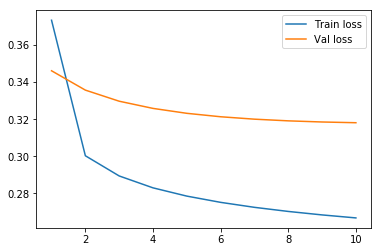

In [10]:
# Plot loss
plt.figure()
plt.plot(x, trainLoss, label="Train loss")
plt.plot(x, valLoss, label="Val loss")
plt.legend()
plt.show()

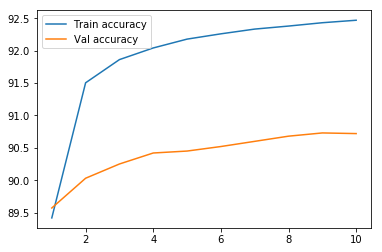

In [11]:
# Plot accuracies
plt.figure()
plt.plot(x, trainAcc, label="Train accuracy")
plt.plot(x, valAcc, label="Val accuracy")
plt.legend()
plt.show()

Finally, load the best stored model, and perform same actions, without any training.

In [13]:
model.load_weights("model_best.pkl")
callbacks = [ConfusionMatrix(numClasses=10, categoricalLabels=True)]
metrics = model.test_generator(testGenerator, testNumIterations, callbacks=callbacks)

loss, accuracy = metrics["Loss"], metrics["Accuracy"]
print("Testing complete. Loss: %2.2f. Accuracy: %2.2f" % (loss, accuracy))
print("Confusion matrix:\n", callbacks[0].confusionMatrix)


Succesfully loaded weights
Testing complete. Loss: 0.32. Accuracy: 90.72
Confusion matrix:
 [[ 964    0    2    1    0    7    2    2    2    0]
 [   0 1120    2    2    1    1    3    2    4    0]
 [  10   40  852   55    5    6   15    5   35    9]
 [   5    2   11  902    1   51    2   11   14   11]
 [   1    3    3    1  887    0   12    2   12   61]
 [  11    2    2   19   15  793    9    1   26   14]
 [  15    5    6    2    8   26  891    2    3    0]
 [   4   17   23    9    7    2    0  896    2   68]
 [   6   30    4   37   12   36    8    5  819   17]
 [   8    8    1    8   14    7    0    9    6  948]]


Nice.